# AN2DL Third Challenge: Visual Question Answering

This kind of problem required us to divide the features extraction process into two parts: the first one related to the images and the second one related to the questions. So we have implemented two different networks: a Convolutional Neural Network for the images task and a Long Short-Term Memory for the sentences. Then, we have concatenated them in order to get the final prediction. 
This was necessary since, unlike the previous assignments, we had to manage two different inputs, one having fixed-size (and then processable with a CNN) and one which is a sequence, so that we had to use a sequence model in order to keep track of the previous inputs. 

Since the dataset had very high-dimensionality, we needed to increase the Ram available with Colab to 25GB.
 
Note : we have reported the description of each passage in the cells below.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import tensorflow as tf
import numpy as np
from PIL import Image
import json
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Dropout
from tensorflow.keras.models import Model, Sequential

# Set the seed for random operations. 
# This let our experiments to be reproducible. 
SEED = 1234
tf.random.set_seed(SEED)
np.random.seed(SEED)
MAX_NUM_WORDS = 10000;
#set the size to which you want to resize the images
img_h = 128 
img_w = 128
# Get current working directory
cwd = os.getcwd()

In [ ]:
labels_dict = {
        '0': 0,
        '1': 1,
        '2': 2,
        '3': 3,
        '4': 4,
        '5': 5,
        'apple': 6,
        'baseball': 7,
        'bench': 8,
        'bike': 9,
        'bird': 10,
        'black': 11,
        'blanket': 12,
        'blue': 13,
        'bone': 14,
        'book': 15,
        'boy': 16,
        'brown': 17,
        'cat': 18,
        'chair': 19,
        'couch': 20,
        'dog': 21,
        'floor': 22,
        'food': 23,
        'football': 24,
        'girl': 25,
        'grass': 26,
        'gray': 27,
        'green': 28,
        'left': 29,
        'log': 30,
        'man': 31,
        'monkeybars': 32,
        'no': 33,
        'nothing': 34,
        'orange': 35,
        'pie': 36,
        'plant': 37,
        'playing': 38,
        'red': 39,
        'right': 40,
        'rug': 41,
        'sandbox': 42,
        'sitting': 43,
        'sleeping': 44,
        'soccer': 45,
        'squirrel': 46,
        'standing': 47,
        'stool': 48,
        'sunny': 49,
        'table': 50,
        'tree': 51,
        'watermelon': 52,
        'white': 53,
        'wine': 54,
        'woman': 55,
        'yellow': 56,
        'yes': 57
}

# Dataset Creation

First of all, we have extracted image ids, questions and answers from the json files and we have stored them in lists.
Moreover, since every label must be of one word, we were required to change the label "monkey bars" into a single-word label. 

In [ ]:
#set the directories of the images and the annotations

img_dir = '/content/VQA_Dataset/Images'
train_annotations_dir = '/content/VQA_Dataset/train_questions_annotations.json'
test_annotations_dir = '/content/VQA_Dataset/test_questions.json'
img_dir = '/content/VQA_Dataset/Images'

In [ ]:

train_ques_open = json.load(open(train_annotations_dir, 'r'))
test_ques_open = json.load(open(test_annotations_dir, 'r'))

train_ques = []
train_ans = []
train_img_ids = []

test_ques = []
test_img_ids = []
test_ques_ids =[]

count = 0
for ques_id in train_ques_open:
   train_ques.append(train_ques_open[ques_id]["question"])
   if (train_ques_open[ques_id]["answer"]== "monkey bars"):
     train_ques_open[ques_id]["answer"] = "monkeybars"
   train_ans.append(train_ques_open[ques_id]["answer"])
   img_path = os.path.join(img_dir,(train_ques_open[ques_id]["image_id"] + ".png" ))
   train_img_ids.append(img_path)

for test_ques_id in test_ques_open:
   test_ques_ids.append(test_ques_id)
   test_ques.append(test_ques_open[test_ques_id]["question"])
   img_path = os.path.join(img_dir,(test_ques_open[test_ques_id]["image_id"] + ".png" ))
   test_img_ids.append(img_path)

We have created a function which returns a numpy array containing the images we wanted to use. The choice of this data structure helped us accelerating the computation.

In [ ]:
def create_img_dataset(train_img_ids, img_h, img_w, a, b):
  train_img = []
  for img_id in train_img_ids[a:b]:
    img = Image.open(img_id)
    img_resized = img.resize(size = (img_h,img_w),resample = Image.ANTIALIAS)
    img_array = np.array(img_resized)
    img_array = img_array[:,:,0:3]
    img_array = img_array/255.0
    train_img.append(img_array)
    
  train_imgs = np.array(train_img)

  return train_imgs

Before the training we have created three numpy arrays containing 20000, 20000 and 18832 images respectively. Every array was saved in a path in our google drive folder and loaded at run time during training.

In [ ]:
#only to create the image dataset
#don't run this cell if you have just created the files
path = '/content/drive/MyDrive/Terzo Assignment' #enter the path in which you want to save the images
file_name = 'data1' #change the name every time you create a new set of images
save_path = os.path.join(path,file_name)
train_imgs = create_img_dataset (train_img_ids, img_h, img_w, 0 , 20000)#data2: 20000-40000 data3:40000-58832  
np.save(save_path, train_imgs)

# Tokenization 

In [ ]:
train_question_tokenizer = Tokenizer(num_words= MAX_NUM_WORDS, oov_token = '<UKN>')
train_question_tokenizer.fit_on_texts(train_ques)
train_question_tokenized = train_question_tokenizer.texts_to_sequences(train_ques)

train_question_wtoi = train_question_tokenizer.word_index
print('Total words in the train questions:', len(train_question_wtoi))
  
max_train_ques_length = max(len(sentence) for sentence in train_question_tokenized)
print('Max train question length:', max_train_ques_length)

train_answer_tokenizer = Tokenizer(num_words= MAX_NUM_WORDS)
train_answer_tokenizer.fit_on_texts(train_ans)
train_answer_tokenized = train_answer_tokenizer.texts_to_sequences(train_ans)
  
train_answer_wtoi = train_answer_tokenizer.word_index
print('Total words in the train answers:', len(train_answer_wtoi))
  
max_train_ans_length = max(len(sentence) for sentence in train_answer_tokenized)
print('Max train answer length:', max_train_ans_length)

Total words in the train questions: 4641
Max train question length: 21
Total words in the train answers: 58
Max train answer length: 1


In [ ]:
#this function is used to extract questions and answers for training
#We cannot use all the data together so this function is called at each training session 
def set_questions_and_answers(a,b):
  train_ans_first = train_answer_tokenized[a:b]
  train_ques_first = train_question_tokenized[a:b]
  return train_ques_first, train_ans_first

In [ ]:
# Test questions tokenizer
def test_tokenizer(test_ques):
  test_question_tokenizer = Tokenizer(num_words= MAX_NUM_WORDS, oov_token = '<UKN>')
  test_question_tokenizer.fit_on_texts(test_ques)
  test_question_tokenized = train_question_tokenizer.texts_to_sequences(test_ques)
  
  test_question_wtoi = test_question_tokenizer.word_index
  print('Total words in the test questions:', len(test_question_wtoi))
  
  max_test_ques_length = max(len(sentence) for sentence in test_question_tokenized)
  print('Max test question length:', max_test_ques_length)

  return test_question_tokenized, max_test_ques_length

# Padding sequences

These functions create the sequences to feed the network for training and for the prediction. The answers (y_train) are one-hot encoded because we are solving a classification problem.



In [ ]:
def pad_train_sequences(train_question_tokenized, train_answer_tokenized, max_train_ques_length, max_train_ans_length):
  # Pad to max train question length
  question_encoder_inputs = pad_sequences(train_question_tokenized, maxlen=max_train_ques_length, padding='pre')
  
  print("Questions encoder inputs shape:", question_encoder_inputs.shape)
  
  # Pad to max train answer length
  answer_encoder_inputs = pad_sequences(train_answer_tokenized, maxlen=max_train_ans_length)
  y_train = tf.keras.utils.to_categorical(answer_encoder_inputs, num_classes = 59)
  print("Answers encoder inputs shape:", answer_encoder_inputs.shape)
  print(y_train.shape)

  return question_encoder_inputs, y_train 

In [ ]:
def pad_test_sequences (test_question_tokenized, max_train_ques_length):
  # pad test sequences to max train question length
  test_inputs = pad_sequences(test_question_tokenized, maxlen=max_train_ques_length, padding='pre')
  
  print("Test inputs shape:", test_inputs.shape)

  return test_inputs

In [ ]:
def create_word_dataset(a, b):
    train_ques_first, train_ans_first = set_questions_and_answers(a, b)
    question_encoder_inputs, y_train = pad_train_sequences(train_ques_first, train_ans_first, max_train_ques_length, max_train_ans_length)

    return question_encoder_inputs, y_train

# Model

The CNN model is obtained with transfer learning. After several attempts, we have realized that VGG19 was the better network for us because it is not too deep ( this is important to reduce the number of parameters and prevent overfitting ) and it is a better feature extractor than VGG16 because it has more convolutional blocks. Indeed, we have also tried other networks (e.g., ResNet and DenseNet), deeper and more complex, with worse results: the networks were better on the accuracy of the training set, but they were not able to generalize to the validation set. This is because the number of parameters was too huge and the networks were too complex for the specific problem we were dealing with. 
Instead, the language model is composed of: an embedding layer, which maps the initial sequence into a smaller space (128 is a good size because we have not a big vocabulary); a LSTM layer with 128 units, regularized by the dropout. 
After the concatenation, we have decided to add a dense layer before the softmax because we wanted to improve the connection between vision and language model.
All the hyperparameters (number of frozen layers, embedding size, LSTM units, dropout rate and number of dense units) were tuned with cross validation but we consider also the total number of parameters of the model.

In [ ]:
def define_model(img_h, img_w ):
  # Define CNN for Image Input
  vision_model = Sequential()
  arch = tf.keras.applications.VGG19(
    include_top = False,
    weights="imagenet",
    input_shape=(img_h,img_w,3)
)
  for layer in arch.layers[:12]:
    layer.trainable = False
  vision_model.add(arch)
  vision_model.add(tf.keras.layers.Flatten())
  
  image_input = Input(shape=(img_h, img_w, 3))
  encoded_image = vision_model(image_input)
  
  # Define RNN for language input
  language_model = Sequential()
  question_input = Input(shape=[max_train_ques_length], dtype='int32')
  embedded_question = Embedding(len(train_question_wtoi) + 1, output_dim=128, input_length=max_train_ques_length)(question_input)
  language_model.add( LSTM(128))
  language_model.add( Dropout(0.2))
  encoded_question = language_model(embedded_question)
  
  # Combine CNN and RNN to create the final model
  merged = tf.keras.layers.concatenate([encoded_question, encoded_image])
  dense = Dense(256, activation = 'relu')(merged)
  output = Dense( len(train_answer_wtoi)+1 , activation='softmax')(dense)
  vqa_model = Model(inputs=[image_input, question_input], outputs=output)
  
  return vqa_model

# Prepare model for training


We have trained the model with a for-loop which manages 20000 images and question at iteration because the dataset was too big to handle all the data together. With the checkpoint we keep track of the best model during the training so we don't lose accuracy .

In [ ]:
def compile_model (vqa_model):
  # Loss
  loss = tf.keras.losses.CategoricalCrossentropy()
  
  # learning rate
  lr = 1e-3
  optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

  # Validation metrics
  metrics = ['accuracy']
  
  # Compile Model
  vqa_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [ ]:
def define_callbacks():
  from datetime import datetime
  cwd = os.getcwd()
  callbacks = []
  now = datetime.now().strftime('%b%d_%H-%M-%S')
  model_name = 'TRANS'
  directory = '/content/drive/MyDrive/Terzo Assignment'
  
  exps_dir = os.path.join(directory, 'translation_experiments')
  if not os.path.exists(exps_dir): os.makedirs(exps_dir)
  exp_dir  = os.path.join(exps_dir ,  model_name + '_' + str(now))
  if not os.path.exists(exp_dir):  os.makedirs(exp_dir)
  ckpt_dir = os.path.join(exp_dir  , 'ckpts')
  if not os.path.exists(ckpt_dir): os.makedirs(ckpt_dir)
  best_dir = os.path.join(ckpt_dir , 'best')


  # Model checkpoint
  ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=best_dir, save_weights_only=True, save_best_only=True, verbose=2)
  callbacks.append(ckpt_callback)
  #lr adapter
  lr_adapter_callback = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
                                            factor=0.2, 
                                            patience=3, 
                                            verbose=1, 
                                            mode='auto', 
                                            min_delta=0.0001, 
                                            cooldown=0)
  callbacks.append(lr_adapter_callback)

    # Early Stopping
  early_stop = True
  if early_stop:
    es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
    callbacks.append(es_callback)

  return callbacks, best_dir

In [ ]:

def train_model(train_ques,train_ans, train_img_ids, callbacks, best_dir, n_samples):
  x = [0,n_samples,2*n_samples,len(train_ques)]
  for i in range(len(x)-1):
    print("\n--------------------------------------------------------------------------------------------------")
    print(f"START TRAINING {i + 1} ")
    print("--------------------------------------------------------------------------------------------------\n")
    path = '/content/drive/MyDrive/Terzo Assignment'
    img_file_name = 'data' + str(i+1) + '.npy'
    img_path = os.path.join(path, img_file_name)
    train_imgs = np.load(img_path)
    question_encoder_inputs, y_train = create_word_dataset(x[i], x[i+1])
    if i==0 :
      vqa_model = define_model(img_h, img_w)
      vqa_model.summary()
      compile_model(vqa_model)
    vqa_model.fit([train_imgs, question_encoder_inputs],
                y_train,
                epochs=50,
                batch_size=20, 
                validation_split=0.2, 
                callbacks=callbacks)
    vqa_model.load_weights(best_dir)

  return vqa_model



In [ ]:
callbacks, best_dir = define_callbacks()
vqa_model = train_model(train_ques,train_ans, train_img_ids, callbacks, best_dir, 20000)


--------------------------------------------------------------------------------------------------
START TRAINING 1 
--------------------------------------------------------------------------------------------------

Questions encoder inputs shape: (20000, 21)
Answers encoder inputs shape: (20000, 1)
(20000, 59)
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 21)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 21, 128)      594176      input_3[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 128, 128, 3) 0                      

# Test prediction


Finally, we have created the dictionary with the predictions. The labels in the answers dictionaries were not the same as the labels_dict we wanted to use so that we needed to manage this difference in order to get a correct prediction.

In [ ]:
def predict_test_image (img_path, question):
  img = Image.open(img_path)
  img_resized = img.resize(size = (img_h,img_w),resample = Image.ANTIALIAS)
  img_array = np.array(img_resized)
  img_array = img_array[:,:,0:3]
  img_array = img_array/255.0
  test_im = [img_array]
  test_im = np.array(test_im)
  pred = vqa_model.predict([test_im,question])
  return pred

In [ ]:
test_question_tokenized, max_test_ques_length = test_tokenizer(test_ques)

test_inputs = pad_test_sequences (test_question_tokenized, max_train_ques_length)

Total words in the test questions: 1374
Max test question length: 18
Test inputs shape: (6372, 21)


In [ ]:
results = {}
test_zip = zip(test_ques_ids,test_img_ids,test_inputs)
test_zip = list(test_zip)
for ques in test_zip:
  question = np.array([list(ques[2])])
  pred = predict_test_image(ques[1],question)
  prediction = np.argmax(pred)
  #Searching the key which refers to the predicted label in the answers dictionary 
  label = next((key for key in train_answer_wtoi if train_answer_wtoi[key] == prediction), None) 
  #add the correct labels_dict label to the dictionary containing the question ids as keys
  results[ques[0]] = labels_dict[label]

In [ ]:
from datetime import datetime
def create_csv(results, results_dir='/content/drive/MyDrive/Terzo Assignment/results'):

    csv_fname = 'results_'
    csv_fname += datetime.now().strftime('%b%d_%H-%M-%S') + '.csv'

    with open(os.path.join(results_dir, csv_fname), 'w') as f:

        f.write('Id,Category\n')

        for key, value in results.items():
            f.write(key + ',' + str(value) + '\n')

In [ ]:
create_csv (results)

# Results

The results were satisfying because the accuracy of the prediction reflects the accuracy computed on the validation set.  We have gained generalization using a large dataset, indeed the performance has improved with a bigger number of data. However this approach cost us a lot of computational resources because we had to increase the RAM avalaible to 25 GB in order to use all the data. 


How is the weather?
sunny


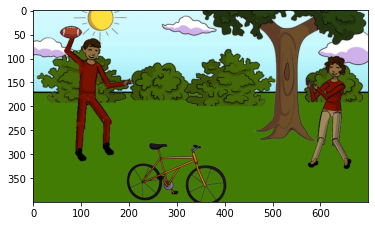

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
question = test_ques[0]
image = mpimg.imread(test_img_ids[0])
pred = results[test_ques_ids[0]]
label = next((key for key in labels_dict if labels_dict[key] == pred), None)

print(question)
print(label)
imgplot = plt.imshow(image)